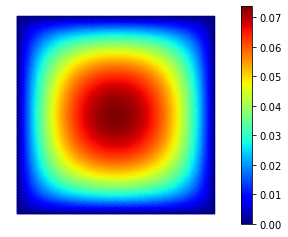

In [1]:
# This code uses scikit-fem library (https://pypi.org/project/scikit-fem/) for FEM


In [1]:
from numpy import ndarray

In [2]:
r"""

This example demonstrates the solution of a slightly more complicated problem
with multiple boundary conditions and a fourth-order differential operator. We
consider the `Kirchhoff plate bending problem
<https://en.wikipedia.org/wiki/Kirchhoff%E2%80%93Love_plate_theory>`_ which
finds its applications in solid mechanics. For a stationary plate of constant
thickness :math:`d`, the governing equation reads: find the deflection :math:`u
: \Omega \rightarrow \mathbb{R}` that satisfies

.. math::
    \frac{Ed^3}{12(1-\nu^2)} \Delta^2 u = f \quad \text{in $\Omega$},
where :math:`\Omega = (0,1)^2`, :math:`f` is a perpendicular force,
:math:`E` and :math:`\nu` are material parameters.
In this example, we analyse a :math:`1\,\text{m}^2` plate of steel with thickness :math:`d=0.1\,\text{m}`.
The Young's modulus of steel is :math:`E = 200 \cdot 10^9\,\text{Pa}` and Poisson
ratio :math:`\nu = 0.3`.

In reality, the operator

.. math::
    \frac{Ed^3}{12(1-\nu^2)} \Delta^2
is a combination of multiple first-order operators:

.. math::
    \boldsymbol{K}(u) = - \boldsymbol{\varepsilon}(\nabla u), \quad \boldsymbol{\varepsilon}(\boldsymbol{w}) = \frac12(\nabla \boldsymbol{w} + \nabla \boldsymbol{w}^T),
.. math::
    \boldsymbol{M}(u) = \frac{d^3}{12} \mathbb{C} \boldsymbol{K}(u), \quad \mathbb{C} \boldsymbol{T} = \frac{E}{1+\nu}\left( \boldsymbol{T} + \frac{\nu}{1-\nu}(\text{tr}\,\boldsymbol{T})\boldsymbol{I}\right),
where :math:`\boldsymbol{I}` is the identity matrix. In particular,

.. math::
    \frac{Ed^3}{12(1-\nu^2)} \Delta^2 u = - \text{div}\,\textbf{div}\,\boldsymbol{M}(u).
There are several boundary conditions that the problem can take.
The *fully clamped* boundary condition reads

.. math::
    u = \frac{\partial u}{\partial \boldsymbol{n}} = 0,
where :math:`\boldsymbol{n}` is the outward normal.
Moreover, the *simply supported* boundary condition reads

.. math::
    u = 0, \quad M_{nn}(u)=0,
where :math:`M_{nn} = \boldsymbol{n} \cdot (\boldsymbol{M} \boldsymbol{n})`.
Finally, the *free* boundary condition reads

.. math::
    M_{nn}(u)=0, \quad V_{n}(u)=0,
where :math:`V_n` is the `Kirchhoff shear force <https://arxiv.org/pdf/1707.08396.pdf>`_. The exact
definition is not needed here as this boundary condition is a
natural one.

The correct weak formulation for the problem is: find :math:`u \in V` such that

.. math::
    \int_\Omega \boldsymbol{M}(u) : \boldsymbol{K}(v) \,\mathrm{d}x = \int_\Omega fv \,\mathrm{d}x \quad \forall v \in V,
where :math:`V` is now a subspace of :math:`H^2` with the essential boundary
conditions for :math:`u` and :math:`\frac{\partial u}{\partial \boldsymbol{n}}`.

Instead of constructing a subspace for :math:`H^2`, we discretise the problem
using the `non-conforming Morley finite element
<https://users.aalto.fi/~jakke74/WebFiles/Slides-Niiranen-ADMOS-09.pdf>`_ which
is a piecewise quadratic :math:`C^0`-continuous element for biharmonic problems.

The full source code of the example reads as follows:

.. literalinclude:: examples/ex02.py
    :start-after: EOF"""
from skfem import *
from skfem.models.poisson import unit_load
import numpy as np

m = (
    MeshTri.init_symmetric()
    .refined(3)
    .with_boundaries(
        {
            "left": lambda x: x[0] == 0,
            "right": lambda x: x[0] == 1,
            "top": lambda x: x[1] == 1,
        }
    )
)

e = ElementTriMorley()
ib = Basis(m, e)


@BilinearForm
def bilinf(u, v, w):
    from skfem.helpers import dd, ddot, trace, eye
    d = 0.1
    E = 200e9
    nu = 0.3

    def C(T):
        return E / (1 + nu) * (T + nu / (1 - nu) * eye(trace(T), 2))

    return d**3 / 12.0 * ddot(C(dd(u)), dd(v))


K = asm(bilinf, ib)
f = 1e6 * asm(unit_load, ib)

D = np.hstack([ib.get_dofs("left"), ib.get_dofs({"right", "top"}).all("u")])

x = solve(*condense(K, f, D=D))

def visualize():
    from skfem.visuals.matplotlib import draw, plot
    ax = draw(m)
    return plot(ib,
                x,
                ax=ax,
                shading='gouraud',
                colorbar=True,
                nrefs=2)

if __name__ == "__main__":
    visualize().show()

ModuleNotFoundError: No module named 'scipy'

In [10]:
print(dir(m1))
#m1.nnodes

NameError: name 'm1' is not defined

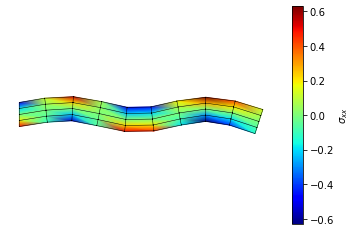

In [41]:
"""Linear elastic eigenvalue problem."""

from skfem import *
from skfem.helpers import dot, ddot, sym_grad
from skfem.models.elasticity import linear_elasticity, linear_stress
import numpy as np

m1 = MeshLine(np.linspace(0, 10, 10))
m2 = MeshLine(np.linspace(0, 1, 5))
m = (m1 * m2).with_boundaries(
    {
        "left": lambda x: x[0] == 0.0
    }
)

e1 = ElementQuad1()

mapping = MappingIsoparametric(m, e1)

e = ElementVector(e1)

gb = Basis(m, e, mapping, 2)

lam = 1.
mu = 1.
K = asm(linear_elasticity(lam, mu), gb)

@BilinearForm
def mass(u, v, w):
    return dot(u, v)

M = asm(mass, gb)

D = gb.get_dofs("left")
y = gb.zeros()

I = gb.complement_dofs(D)

L, x = solve(*condense(K, M, I=I),
             solver=solver_eigen_scipy_sym(k=6, sigma=0.0))

y = x[:, 4]

# calculate stress
sgb = gb.with_element(ElementVector(e))
C = linear_stress(lam, mu)
yi = gb.interpolate(y)
sigma = sgb.project(C(sym_grad(yi)))

def visualize():
    from skfem.visuals.matplotlib import plot, draw
    M = MeshQuad(np.array(m.p + .5 * y[gb.nodal_dofs]), m.t)
    ax = draw(M)
    return plot(M,
                sigma[sgb.nodal_dofs[0]],
                ax=ax,
                colorbar='$\sigma_{xx}$',
                shading='gouraud')

if __name__ == "__main__":
    visualize().show()

In [1]:
r"""Contact problem.

Mortar methods allow setting interface conditions on non-matching meshes.
They are useful also when solving variational inequalities such as
`elastic contact problems <https://arxiv.org/abs/1902.09312>`_.
"""

import numpy as np
from skfem import *
from skfem.experimental.supermeshing import intersect, elementwise_quadrature
from skfem.models.elasticity import (linear_elasticity, lame_parameters,
                                     linear_stress)
from skfem.helpers import dot, sym_grad, jump, mul
from skfem.io.json import from_file
from pathlib import Path


# create meshes
mesh_file = './ex04_mesh.json'
m1 = from_file(mesh_file)
m2 = (
    (MeshLine(np.linspace(1, 2, 6)) * MeshLine(np.linspace(-1, 1, 10)))
    .refined()
    .with_boundaries({
        'contact': lambda x: x[0] == 1.0,
        'dirichlet': lambda x: x[0] == 2.0,
    })
)

e1 = ElementVector(ElementTriP2())
e2 = ElementVector(ElementQuad2())

# create trace meshes and project
m1t, orig1 = m1.trace('contact', mtype=MeshLine, project=lambda p: p[1:])
m2t, orig2 = m2.trace('contact', mtype=MeshLine, project=lambda p: p[1:])

# create a supermesh for integration
m12, t1, t2 = intersect(m1t, m2t)

bases = [
    Basis(m1, e1),
    Basis(m2, e2),
]

fbases = [
    FacetBasis(m1, e1,
               quadrature=elementwise_quadrature(m1t, m12, t1),
               facets=orig1[t1]),
    FacetBasis(m2, e2,
               quadrature=elementwise_quadrature(m2t, m12, t2),
               facets=orig2[t2]),
]

# problem definition
youngs_modulus = 1000.0
poisson_ratio = 0.3

weakform = linear_elasticity(*lame_parameters(youngs_modulus, poisson_ratio))
C = linear_stress(*lame_parameters(youngs_modulus, poisson_ratio))

alpha = 1000
limit = 0.3

# mortar forms
@BilinearForm
def bilin_mortar(u, v, w):
    ju, jv = jump(w, dot(u, w.n), dot(v, w.n))
    mu = .5 * dot(w.n, mul(C(sym_grad(u)), w.n))
    mv = .5 * dot(w.n, mul(C(sym_grad(v)), w.n))
    return ((1. / (alpha * w.h) * ju * jv - mu * jv - mv * ju)
            * (np.abs(w.x[1]) <= limit))

def gap(x):
    return (1. - np.sqrt(1. - x[1] ** 2))

@LinearForm
def lin_mortar(v, w):
    jv = jump(w, dot(v, w.n))
    mv = .5 * dot(w.n, mul(C(sym_grad(v)), w.n))
    return ((1. / (alpha * w.h) * gap(w.x) * jv - gap(w.x) * mv)
            * (np.abs(w.x[1]) <= limit))

# fix mesh parameter and normals from m2
params = {
    'h': fbases[1].mesh_parameters(),
    'n': -fbases[1].normals,
}

# assemble the block system
A = asm(weakform, bases, to=list)
B = asm(bilin_mortar, fbases, fbases, **params, to=list)
b = asm(lin_mortar, fbases, **params, to=list)

K = bmat([[A[0] + B[0], B[2]],
          [B[1], A[1] + B[3]]], 'csr')
f = np.concatenate(b)

D1 = bases[0].get_dofs('dirichlet').all()
D2 = bases[1].get_dofs('dirichlet').all() + K.blocks[0]

# initialize boundary conditions
y1 = bases[0].zeros()
y2 = bases[1].zeros()
y1[bases[0].get_dofs('dirichlet').all('u^1')] = .1
y = np.concatenate((y1, y2))

# linear solve
y = solve(*condense(K, f, D=np.concatenate((D1, D2)), x=y))

# create a displaced mesh for visualization
sf = 1
y1, y2 = np.split(y, K.blocks)
mdefo1 = m1.translated(sf * y1[bases[0].nodal_dofs])
mdefo2 = m2.translated(sf * y2[bases[1].nodal_dofs])

# calculate von Mises stress
s1, s2 = {}, {}
dg1 = bases[0].with_element(ElementTriDG(ElementTriP1()))
dg2 = bases[1].with_element(ElementQuadDG(ElementQuad1()))
u1 = bases[0].interpolate(y1)
u2 = bases[1].interpolate(y2)

for i in [0, 1]:
    for j in [0, 1]:
        s1[i, j] = dg1.project(C(sym_grad(u1))[i, j])
        s2[i, j] = dg2.project(C(sym_grad(u2))[i, j])

s1[2, 2] = poisson_ratio * (s1[0, 0] + s1[1, 1])
s2[2, 2] = poisson_ratio * (s2[0, 0] + s2[1, 1])

vonmises1 = np.sqrt(.5 * ((s1[0, 0] - s1[1, 1]) ** 2 +
                          (s1[1, 1] - s1[2, 2]) ** 2 +
                          (s1[2, 2] - s1[0, 0]) ** 2 +
                          6. * s1[0, 1] ** 2))

vonmises2 = np.sqrt(.5 * ((s2[0, 0] - s2[1, 1]) ** 2 +
                          (s2[1, 1] - s2[2, 2]) ** 2 +
                          (s2[2, 2] - s2[0, 0]) ** 2 +
                          6. * s2[0, 1] ** 2))


def visualize():
    from skfem.visuals.matplotlib import plot, draw
    pdg1 = Basis(mdefo1, dg1.elem)
    pdg2 = Basis(mdefo2, dg2.elem)
    ax = plot(pdg1,
              vonmises1,
              shading='gouraud',
              colorbar=r"$\sigma_{\mathrm{mises}}$")
    draw(mdefo1, ax=ax)
    plot(pdg2, vonmises2, ax=ax, nrefs=3, shading='gouraud')
    draw(mdefo2, ax=ax)
    return ax


if __name__ == "__main__":
    visualize().show()

ImportError: cannot import name 'ndarray' from 'numpy' (unknown location)

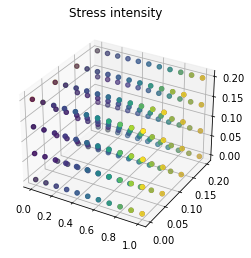

In [2]:
from fenics import *
from ufl import nabla_grad
from ufl import nabla_div


# Scaled variables
L = 1; W = 0.2
mu = 1
rho = 1
delta = W/L
gamma = 0.4*delta**2
beta = 1.25
lambda_ = beta
g = gamma

# Create mesh and define function space
mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 10, 3, 3)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol

bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)

# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, 0, -rho*g))
T = Constant((0, 0, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
plot(u, title='Displacement', mode='displacement')

# Plot stress
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)
plot(von_Mises, title='Stress intensity')

# Compute magnitude of displacement
u_magnitude = sqrt(dot(u, u))
u_magnitude = project(u_magnitude, V)
plot(u_magnitude, 'Displacement magnitude')
# print('min/max u:',
#       u_magnitude.vector().array().min(),
#       u_magnitude.vector().array().max())


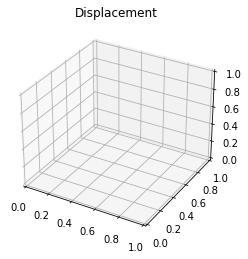

In [3]:
# Plot solution
plot(u, title='Displacement', mode='displacement')

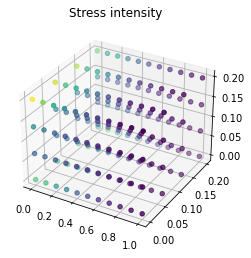

In [4]:
plot(von_Mises, title='Stress intensity')

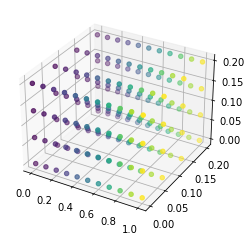

In [5]:
plot(u_magnitude, 'Displacement magnitude')

In [11]:
# linear elastic problem: Source (https://fenics-solid-tutorial.readthedocs.io/en/latest/2DPlaneStrain/2D_Elasticity.html)

import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
# Bottom boundary
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))

# Strain function
def epsilon(u):
    return fe.sym(fe.grad(u))

# Stress function
def sigma(u):
    return lambda_*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


ModuleNotFoundError: No module named 'fenics'

In [79]:
# --------------------
# Parameters
# --------------------

# Density
rho = fe.Constant(200.0)

# Young's modulus and Poisson's ratio
E = 0.02e9
nu = 0.0

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)         # general case
lambda_ = 2*mu*lambda_/(lambda_+2*mu)  # for plane stress
mu = E/2/(1+nu)

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20    # Number of elements

# Load
g_z = -2.9575e5
b_z = -10000.0
g = fe.Constant((0.0, g_z))
b = fe.Constant((0.0, b_z))

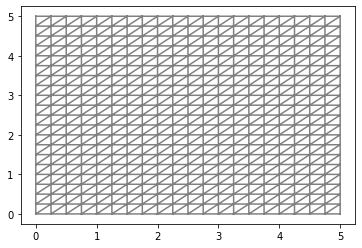

In [80]:
# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)  # point 1 - lower left
                                                                           # point 2 - top right

fe.plot(mesh)
plt.show()

In [81]:
# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

In [82]:
# --------------------
# Boundary conditions
# --------------------
# fixed bottom:
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)  # fixes points at the bottom in both X and Y
#bc = fe.DirichletBC(V.sub(1), 0.0, bottom)  # fixes the Y direction

# Neumann conditions for the top:
top = fe.AutoSubDomain(lambda x: fe.near(x[1], l_y))
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)   # Definition of Neumann boundary condition domain
boundaries.set_all(0)
top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

In [83]:
# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = rho*fe.dot(b, u_test)*fe.dx + fe.inner(g, u_test)*ds(1)

# --------------------
# Init the solver
# --------------------
u = fe.Function(V)
A, L = fe.assemble_system(a, l, bc)
problem = fe.LinearVariationalProblem(a,l,u,bc)
solver = fe.LinearVariationalSolver(problem)

# --------------------
# Solving
# --------------------
fe.solve(A, u.vector(), L)

1

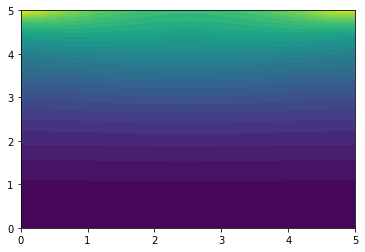

In [84]:
fe.plot(u.sub(0))
plt.show()


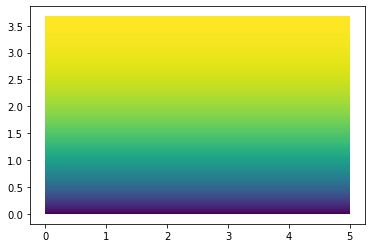

In [76]:
fe.plot(u, mode="displacement")
plt.show()

In [85]:
a = u.vector()
a.vec().getArray()


array([ 4.37754626e-03, -1.31910602e+00,  3.21098026e-03, -1.31308360e+00,
        4.13533646e-03, -1.32075700e+00,  2.61962051e-03, -1.30057083e+00,
        3.23314305e-03, -1.31407073e+00,  3.87964841e-03, -1.32160122e+00,
        2.23241728e-03, -1.28165719e+00,  2.65726030e-03, -1.30120324e+00,
        3.21057020e-03, -1.31479598e+00,  3.65813545e-03, -1.32214577e+00,
        1.93505479e-03, -1.25639968e+00,  2.25744565e-03, -1.28209965e+00,
        2.68982638e-03, -1.30178661e+00,  3.15465223e-03, -1.31531913e+00,
        3.47952019e-03, -1.32254379e+00,  1.68451533e-03, -1.22483382e+00,
        1.94957241e-03, -1.25673725e+00,  2.29255259e-03, -1.28256371e+00,
        2.70256826e-03, -1.30226142e+00,  3.08557400e-03, -1.31571533e+00,
        3.33934588e-03, -1.32285860e+00,  1.46265703e-03, -1.18698128e+00,
        1.69273211e-03, -1.22510983e+00,  1.97623497e-03, -1.25711221e+00,
        2.32414290e-03, -1.28297978e+00,  2.69682045e-03, -1.30264301e+00,
        3.01715808e-03, -